In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import compress
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from allen_v1dd.client import OPhysClient

%load_ext autoreload
%autoreload 2

In [2]:
def get_mouse_name(mouse_id):
    """Given a mouse ID (int), return the mouse name (str) tp 
    index the metrics dataframe correctly
    
    Args:
        mouse_id (int): Mouse ID
        
    Returns:
        str: Mouse name
    """

    mouse_id_mapping = {
        427836: "slc5",
        438833: "slc4",
        416296: "teto1",
        409828: "slc2",
    }

    return mouse_id_mapping[mouse_id]

In [3]:
def get_session_id(session, plane=None):
    """Create a unique session ID for a given session and plane (optional) to help
    with saving data.
    
    Args:
        session (ophys_session): OPhys session object
        plane (int): Plane number; default=None
    
    Returns:
        str: Unique session ID
    """

    if plane:
        return (
            "M"
            + str(session.get_mouse_id())
            + "_"
            + str(session.get_column_id())
            + str(session.get_volume_id())
            + "_"
            + str(plane)
        )
    else:
        return (
            "M"
            + str(session.get_mouse_id())
            + "_"
            + str(session.get_column_id())
            + str(session.get_volume_id())
        )

In [4]:
def select_rois(session, plane, metrics_df=None, unduplicated=False):
    """Select ROIs for a given session and plane, find unduplicated ROIs if needed
    by using the metrics dataframe.
    
    Args:
        session (ophys_session): OPhys session object
        plane (int): Plane number
        metrics_df (pd.DataFrame): Metrics dataframe; default=None
        unduplicated (bool): Whether to find unduplicated ROIs; default=False
    
    Returns:
        list: List of ROIs
    """
    
    rois = session.get_rois(plane)
    if unduplicated:
        if metrics_df is not None:
            rois = metrics_df[
                (metrics_df["mouse_id"] == get_mouse_name(session.get_mouse_id()))
                & (metrics_df["column"] == str(session.get_column_id()))
                & (metrics_df["volume"] == str(session.get_volume_id()))
                & (metrics_df["plane"] == plane)
            ].cell_index.values
            return list(rois)
        else:
            assert "Cannot find unduplicated ROIs without metrics dataframe"
    else:
        return list(
            compress(
                rois,
                session.is_roi_valid(plane=plane),
            )
        )

In [5]:
def get_mean_dff_traces(
    session,
    stimulus_type,
    plane,
    folder_name="/home/naomi/Desktop/data",
):
    
    """Calculate the mean DFF traces for a given session, stimulus type, and plane.
    Save the mean DFF traces locally (to save time when re-running) and return the dataframe.
    If already calculated and saved locally, just load in the dataframe.

    Stmulus types:
    - "drifting_gratings_full"
    - "drifting_gratings_windowed"
    - "locally_sparse_noise"
    - "natural_images"
    - "natural_images_12"
    - "spontaneous"
    - "natural_movie"

    Args:
        session (ophys_session): OPhys session object
        stimulus_type (str): Stimulus type
        plane (int): Plane number
        folder_name (str): Folder name to save mean DFF traces; default="/home/naomi/Desktop/data"
    
    Returns:
        pd.DataFrame: Mean DFF traces dataframe
    """

    ## Check what stimulus type is being used and set the folder name accordingly; throw error if invalid
    if stimulus_type == "drifting_gratings_full":
        folder = "V1dd_calc_mean_responses_fullfieldDG"
    elif stimulus_type == "drifting_gratings_windowed":
        folder = "V1dd_calc_mean_responses_windowedDG"
    elif stimulus_type == "natural_images_12":
        folder = "V1dd_calc_mean_responses_NS12"
    elif stimulus_type == "natural_images":
        folder = "V1dd_calc_mean_responses_NS118"
    elif stimulus_type == "spontaneous":
        folder = "V1dd_calc_mean_responses_spont"
    elif stimulus_type == "natural_movie":
        folder = "V1dd_calc_mean_responses_natmovie"
    elif stimulus_type == "locally_sparse_noise":
        folder = "V1dd_calc_mean_responses_lsn"
    else:
        assert "Invalid stimulus type"

    ## Get the unique session ID string for the plane
    session_id = get_session_id(session=session, plane=plane)

    ## Check if the mean traces df is already calculated and saved locally
    if os.path.isfile(
        os.path.join(
            folder_name,
            folder,
            f"{session_id}_mean_response_df.pkl",
        )
    ):
        mean_response_df = pd.read_pickle(
            os.path.join(
                folder_name,
                folder,
                f"{session_id}_mean_response_df.pkl",
            )
        )
        return mean_response_df

    ## Load in DFF traces
    dff_traces = session.get_traces(plane=plane, trace_type="dff")

    ## Load in stimulus table and drop any rows with NA values
    stimulus_table, _ = session.get_stimulus_table(stimulus_type)
    stimulus_table = stimulus_table.dropna()

    ## Grab the start times and end times of each stimulus
    stim_starts = stimulus_table.start.values
    stim_ends = stimulus_table.end.values

    ## Iterate through each pair of start / end and calculate mean DFOF value during stimulus for each ROI 
    # **note: this is calculated for EVERY ROI, including duplicated ROIS
    mean_dff_traces = []
    all_rois = select_rois(session, plane, metrics_df=None, unduplicated=False)
    for roi in all_rois:
        roi_mean_dff_trace = []
        roi_dff_trace = dff_traces[roi]
        for start, end in zip(stim_starts, stim_ends):
            if len(roi_dff_trace[roi_dff_trace.time < start]) > 0:
                start_idx = np.where(roi_dff_trace.time < start)[0][-1]
            else:
                roi_mean_dff_trace.append(np.nan)
                continue

            if len(roi_dff_trace[roi_dff_trace.time > end]) > 0:
                end_idx = np.where(roi_dff_trace.time > end)[0][0]
            else:
                roi_mean_dff_trace.append(np.nan)
                continue

            roi_mean_dff_trace.append(np.mean(roi_dff_trace[start_idx:end_idx].values))

        mean_dff_traces.append(roi_mean_dff_trace)

    ## Convert mean traces list into a dataframe and set column name as ROI index
    mean_dff_traces_df = pd.DataFrame(data=mean_dff_traces).T
    mean_dff_traces_df.columns = all_rois

    ## Save mean traces df locally
    pd.to_pickle(
        mean_dff_traces_df,
        os.path.join(
            folder_name,
            folder,
            f"{session_id}_mean_response_df.pkl",
        ),
    )
    return mean_dff_traces_df

In [6]:
## path to NWB data
base_folder = "/home/naomi/Desktop/data/V1dd_nwbs"
client = OPhysClient(base_folder)

# Load all session IDs
session_ids = client.get_all_session_ids()

In [7]:
## Load cell_info dataframe (all the metrics across all cells / mice)
ARTIFACT_DIR = Path('/home/naomi/Desktop/code/v1dd-public/artifacts')
csv_tag = "_240610"

def load_and_preprocess(file_name, mouse_id):
    # remove duplicate neurons
    df = pd.read_csv(ARTIFACT_DIR / file_name, dtype={'column': str, 'volume': str, '2p3p': str, 'valid_not_duplicate': bool}, low_memory=False)
    df.insert(1, 'mouse_id', mouse_id, True)
    
    # remove all cells in the column 1 that are 2P (keeps the 3P)
    df = df[~((df["column"] == '1') & (df["2p3p"] == '2'))]
    df = df[df["valid_not_duplicate"]]
    return df

# Load and preprocess the data
slc2 = load_and_preprocess(f'slc2_all_stim_metrics{csv_tag}.csv', "slc2")
slc4 = load_and_preprocess(f'slc4_all_stim_metrics{csv_tag}.csv', "slc4")
slc5 = load_and_preprocess(f'slc5_all_stim_metrics{csv_tag}.csv', "slc5")
teto1 = load_and_preprocess(f'teto1_all_stim_metrics{csv_tag}.csv', "teto1")
cell_info = pd.concat([slc2, slc4, slc5, teto1], ignore_index=True)

cell_info.head()

,Unnamed: 0.1,mouse_id,Unnamed: 0,valid_cell_index,cell_index,col_vol,column,volume,plane,x,...,dgw_pref_dir,dgf_osi,dgw_osi,dgf_dsi,dgw_dsi,dgf_ls,dgw_ls,ns12_ls,ns118_ls,nm_ls
0,8542,slc2,8542,0,0,16,1,6,0,236,...,150,0.214924,0.485850,0.143261,0.394904,0.650162,0.670042,0.941426,0.943378,0.930728
1,8543,slc2,8543,1,1,16,1,6,0,159,...,90,0.765341,0.699801,0.934434,0.180604,0.914330,0.874348,0.962018,0.940841,0.954807
2,8544,slc2,8544,2,2,16,1,6,0,193,...,240,0.447789,0.317350,0.389030,0.267353,0.655039,0.657950,0.954018,0.956597,0.921463
3,8545,slc2,8545,3,3,16,1,6,0,230,...,0,0.661951,0.464806,0.056502,0.402281,0.667079,0.674886,0.944030,0.944862,0.933212
4,8546,slc2,8546,4,4,16,1,6,0,61,...,330,0.503441,0.748724,0.523120,1.000000,0.684561,0.845968,0.962426,0.954630,0.959651


In [69]:
## Calculate running speed correlation with dF/F traces for 4 different stimulus types across all sessions / planes

# Define stimulus types
stim_types = [
    "drifting_gratings_full", 
    "drifting_gratings_windowed",
    "natural_images",
    "natural_images_12",
             ]

running_threshold = 0.05 # threshold for speed to be considered "running" (after running speed normalization)

# Initialize results dictionary
run_corr_results = {
    "mouse_id": [],
    "session_id": [],
    "cell_index": [],
    "volume": [],
    "column": [],
    "plane": [],
    "depth": [], 
    "run_corr_DGF": [],
    "run_corr_DGW": [],
    "run_corr_NI": [],
    "run_corr_NI12": [],
    "run_corr_shuf_DGF": [],
    "run_corr_shuf_DGW": [],
    "run_corr_shuf_NI": [],
    "run_corr_shuf_NI12": [],
}

# Iterate through every session
for session_id in session_ids:

    # Load a session
    session = client.load_ophys_session(session_id)
    column = session.get_column_id()
    volume = session.get_volume_id()
    print(f"... Loaded [Session ID: {session_id}, Column: {column}, Volume: {volume}]")

    # Load running speed and normalize to [0, 1]
    running_speed = session.get_running_speed()
    running_speed_normed = running_speed.values / running_speed.values.max()
    running_speed_normed = np.clip(running_speed_normed, 0, 1)
    frac_time_running = running_speed_normed[running_speed_normed > running_threshold].shape[0] / running_speed_normed.shape[0]

    # Skip sessions with too little running or too much running
    if frac_time_running < 0.1:
        continue
    if frac_time_running > 0.9:
        continue

    # Iterate through every plane
    for plane in session.get_planes():

        # Check if session has nonduplicated ROIs
        unduplicated_rois = select_rois(session, plane, metrics_df=cell_info, unduplicated=True)
        if len(unduplicated_rois) < 1:
            continue

        for cell_idx in unduplicated_rois:
            run_corr_results["session_id"].append(session_id)
            run_corr_results["cell_index"].append(cell_idx)
            run_corr_results["volume"].append(volume)
            run_corr_results["column"].append(column)
            run_corr_results["plane"].append(plane)
            run_corr_results["depth"].append(session.get_plane_depth(plane))
            run_corr_results["mouse_id"].append(get_mouse_name(session.get_mouse_id()))

        # Iterate through every stimulus type
        for stim_type in stim_types:

            # Load stimulus table
            try:
                stim_table, stim_meta = session.get_stimulus_table(stim_type)
                stim_table = stim_table.dropna()
            except:
                # Save results
                if stim_type == "drifting_gratings_full":
                    run_corr_results["run_corr_DGF"].append(np.nan)
                    run_corr_results["run_corr_shuf_DGF"].append(np.nan)
                elif stim_type == "drifting_gratings_windowed":
                    run_corr_results["run_corr_DGW"].append(np.nan)
                    run_corr_results["run_corr_shuf_DGW"].append(np.nan)
                elif stim_type == "natural_images_12":
                    run_corr_results["run_corr_NI12"].append(np.nan)
                    run_corr_results["run_corr_shuf_NI12"].append(np.nan)
                elif stim_type == "natural_images":
                    run_corr_results["run_corr_NI"].append(np.nan)
                    run_corr_results["run_corr_shuf_NI"].append(np.nan)
                continue

            # Get stimulus start and end times
            stim_starts = stim_table.start.values
            stim_ends = stim_table.end.values

            # Iterate through each pair of start / end and calculate mean running speed in each trial
            mean_running_speed = np.zeros(len(stim_starts))
            count = 0 
            for start, end in zip(stim_starts, stim_ends):
                start_idx = np.where(running_speed.time < start)[0][-1]
                end_idx = np.where(running_speed.time > end)[0][0]
                mean_running_speed[count] = (np.mean(running_speed_normed[start_idx:end_idx]))
                count += 1

            # Get mean dF/F traces for all ROIs
            mean_dff_traces = get_mean_dff_traces(session, stim_type, plane)
            mean_dff_traces = mean_dff_traces.dropna()
            mean_dff_traces = mean_dff_traces[unduplicated_rois]

            # Pull out trial indices to make sure they match with running speed
            trial_indices = mean_dff_traces.index.values

            # Iterate through each ROI and calculate correlation with running speed
            for index, cell_idx in enumerate(mean_dff_traces.columns):
                corr = pearsonr(mean_dff_traces[cell_idx], mean_running_speed[trial_indices])[0]
                corr_shuffled = pearsonr(mean_dff_traces[cell_idx], np.random.permutation(mean_running_speed[trial_indices]))[0]
        
                # Save results
                if stim_type == "drifting_gratings_full":
                    run_corr_results["run_corr_DGF"].append(corr)
                    run_corr_results["run_corr_shuf_DGF"].append(corr_shuffled)
                elif stim_type == "drifting_gratings_windowed":
                    run_corr_results["run_corr_DGW"].append(corr)
                    run_corr_results["run_corr_shuf_DGW"].append(corr_shuffled)
                elif stim_type == "natural_images_12":
                    run_corr_results["run_corr_NI12"].append(corr)
                    run_corr_results["run_corr_shuf_NI12"].append(corr_shuffled)
                elif stim_type == "natural_images":
                    run_corr_results["run_corr_NI"].append(corr)
                    run_corr_results["run_corr_shuf_NI"].append(corr_shuffled)
        
run_corr_df = pd.DataFrame(run_corr_results)
run_corr_df.to_csv("run_corr_results.csv")

... Loaded [Session ID: M409828_11, Column: 1, Volume: 1]
... Loaded [Session ID: M409828_12, Column: 1, Volume: 2]
... Loaded [Session ID: M409828_13, Column: 1, Volume: 3]
... Loaded [Session ID: M409828_14, Column: 1, Volume: 4]
... Loaded [Session ID: M409828_15, Column: 1, Volume: 5]
... Loaded [Session ID: M409828_16, Column: 1, Volume: 6]
... Loaded [Session ID: M409828_17, Column: 1, Volume: 7]
... Loaded [Session ID: M409828_18, Column: 1, Volume: 8]
... Loaded [Session ID: M409828_19, Column: 1, Volume: 9]
... Loaded [Session ID: M409828_1a, Column: 1, Volume: a]
... Loaded [Session ID: M409828_1b, Column: 1, Volume: b]
... Loaded [Session ID: M409828_1c, Column: 1, Volume: c]
... Loaded [Session ID: M409828_1d, Column: 1, Volume: d]
... Loaded [Session ID: M409828_1e, Column: 1, Volume: e]
... Loaded [Session ID: M409828_1f, Column: 1, Volume: f]
... Loaded [Session ID: M409828_21, Column: 2, Volume: 1]
... Loaded [Session ID: M409828_22, Column: 2, Volume: 2]
... Loaded [Se

In [20]:
run_corr_df = pd.read_csv("run_corr_results.csv")
run_corr_df.head()

/tmp/ipykernel_10375/2871252474.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  run_corr_df = pd.read_csv("run_corr_results.csv")


,Unnamed: 0,mouse_id,session_id,cell_index,volume,column,plane,depth,run_corr_DGF,run_corr_DGW,run_corr_NI,run_corr_NI12,run_corr_shuf_DGF,run_corr_shuf_DGW,run_corr_shuf_NI,run_corr_shuf_NI12
0,0,slc2,M409828_17,0,7,1,0,525,-0.152812,-0.019488,-0.004113,-0.024278,0.004053,-0.015984,0.021266,-0.028403
1,1,slc2,M409828_17,1,7,1,0,525,-0.020068,-0.036952,0.067465,-0.035108,0.089150,-0.085376,-0.025301,0.018278
2,2,slc2,M409828_17,2,7,1,0,525,-0.056900,0.057928,0.003059,0.013296,-0.065320,0.018499,0.094569,-0.011642
3,3,slc2,M409828_17,3,7,1,0,525,0.258918,0.092752,0.035555,0.075139,0.077294,0.076161,-0.021278,-0.053693
4,4,slc2,M409828_17,4,7,1,0,525,-0.000123,0.021251,-0.044554,-0.021424,-0.015950,0.010619,-0.008816,-0.044681


In [21]:
run_corr_df['column'] = run_corr_df['column'].astype(str)
run_corr_df['volume'] = run_corr_df['volume'].astype(str)

### Figure plotting

In [22]:
fontsize=13
mouse_colors = {'slc2': "#66CCEE", 'slc4': "#228833", 'slc5': '#CCBB44', 'teto1': '#EE6677'}
mice = ['slc2', 'slc4', 'slc5', 'teto1']
mouse_ids = ["M409828", "M416296", "M427836", "M438833"]
mouse_mapping = {
    "M409828": "slc2",
    "M416296": "slc4",
    "M427836": "slc5",
    "M438833": "teto1"
}
z_groups_high_to_low = [[650, 675, 700, 725], [575, 600, 625], [500, 525, 550], [482, 498, 514], [434, 450, 466], \
    [386, 402, 418], [338, 354, 370], [290, 306, 322], [242, 258, 274], [194, 210, 226], [146, 162, 178], [98, 114, 130], [50, 66, 82]]
z_groups_low_to_high = [[50, 66, 82], [98, 114, 130], [146, 162, 178], [194, 210, 226], [242, 258, 274], [290, 306, 322], [338, 354, 370], \
    [386, 402, 418], [434, 450, 466], [482, 498, 514], [500, 525, 550], [575, 600, 625], [650, 675, 700, 725]]

In [37]:
run_corr_df

,Unnamed: 0,mouse_id,session_id,cell_index,volume,column,plane,depth,run_corr_DGF,run_corr_DGW,run_corr_NI,run_corr_NI12,run_corr_shuf_DGF,run_corr_shuf_DGW,run_corr_shuf_NI,run_corr_shuf_NI12
0,0,slc2,M409828_17,0,7,1,0,525,-0.152812,-0.019488,-0.004113,-0.024278,0.004053,-0.015984,0.021266,-0.028403
1,1,slc2,M409828_17,1,7,1,0,525,-0.020068,-0.036952,0.067465,-0.035108,0.089150,-0.085376,-0.025301,0.018278
2,2,slc2,M409828_17,2,7,1,0,525,-0.056900,0.057928,0.003059,0.013296,-0.065320,0.018499,0.094569,-0.011642
3,3,slc2,M409828_17,3,7,1,0,525,0.258918,0.092752,0.035555,0.075139,0.077294,0.076161,-0.021278,-0.053693
4,4,slc2,M409828_17,4,7,1,0,525,-0.000123,0.021251,-0.044554,-0.021424,-0.015950,0.010619,-0.008816,-0.044681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74090,74090,slc4,M438833_55,195,5,5,5,514,0.022510,0.213796,-0.025908,0.001210,0.001463,0.079046,0.052862,-0.030358
74091,74091,slc4,M438833_55,212,5,5,5,514,-0.015853,-0.035146,0.033943,0.059426,-0.071764,0.048391,0.037799,0.001310
74092,74092,slc4,M438833_55,218,5,5,5,514,-0.105015,-0.074738,0.017857,0.026549,0.013045,0.004796,0.011973,-0.048220
74093,74093,slc4,M438833_55,224,5,5,5,514,-0.096182,-0.072156,0.008056,0.003591,0.051810,-0.042987,0.019451,0.024639


In [23]:
# run_corr_df['mouse_id'] = run_corr_df['session_id'].apply(lambda x: x.split('_')[0])
# run_corr_df['mouse_name'] = run_corr_df['mouse_id'].apply(lambda x: mouse_mapping[x])

cell_info_copy = cell_info.copy()
combined_df = cell_info_copy.merge(run_corr_df, how='left', on=['mouse_id', 'column', 'volume', 'plane', 'cell_index'])

combined_df.to_csv("combined_df.csv")

In [64]:
sub_combined_df = combined_df[['mouse_id', 
                               'col_vol', 
                               'cell_index', 
                               'depth',
                               'run_corr_DGF', 
                               'run_corr_DGW', 
                               'run_corr_NI', 
                               'run_corr_NI12', 
                               'run_corr_shuf_DGF',
                               'run_corr_shuf_DGW',
                               'run_corr_shuf_NI',
                               'run_corr_shuf_NI12',
                               ]].dropna()

assert len(sub_combined_df.dropna()) == len(sub_combined_df) # make sure no NaN values
assert len(sub_combined_df) == len(run_corr_df) # make sure all data is here

sub_combined_df.head()

,mouse_id,col_vol,cell_index,depth,run_corr_DGF,run_corr_DGW,run_corr_NI,run_corr_NI12,run_corr_shuf_DGF,run_corr_shuf_DGW,run_corr_shuf_NI,run_corr_shuf_NI12
127,slc2,17,0,525.0,-0.152812,-0.019488,-0.004113,-0.024278,0.004053,-0.015984,0.021266,-0.028403
128,slc2,17,1,525.0,-0.020068,-0.036952,0.067465,-0.035108,0.089150,-0.085376,-0.025301,0.018278
129,slc2,17,2,525.0,-0.056900,0.057928,0.003059,0.013296,-0.065320,0.018499,0.094569,-0.011642
130,slc2,17,3,525.0,0.258918,0.092752,0.035555,0.075139,0.077294,0.076161,-0.021278,-0.053693
131,slc2,17,4,525.0,-0.000123,0.021251,-0.044554,-0.021424,-0.015950,0.010619,-0.008816,-0.044681


In [65]:
## Bootstrapping to create plots -- should take about 13 seconds for cell to run

n_bootstrap = 1000
n_z_groups = len(z_groups_high_to_low)
n_mice = len(mice)
stim_types = ['DGF', 'DGW', 'NI', 'NI12']
n_stim_types = len(stim_types)
bootstrapped_data = np.zeros((n_stim_types, n_bootstrap, n_z_groups, n_mice))
bootstrapped_data_shuf = np.zeros((n_stim_types, n_bootstrap, n_z_groups, n_mice))

data_df = sub_combined_df[['mouse_id', 'col_vol', 'cell_index', 'depth', 'run_corr_DGF', 'run_corr_DGW', 'run_corr_NI', 'run_corr_NI12']]
shuf_data_df = sub_combined_df[['mouse_id', 'col_vol', 'cell_index', 'depth', 'run_corr_shuf_DGF', 'run_corr_shuf_DGW', 'run_corr_shuf_NI', 'run_corr_shuf_NI12']]

for s, stim_type in enumerate(stim_types):
    for m, mouse_id in enumerate(mice):
        for z, z_group in enumerate(z_groups_high_to_low):
            col_name = [x for x in data_df.columns.values if stim_type in x][0]
            plane = data_df['depth'].isin(z_group) & data_df['mouse_id'].isin([mouse_id])
            data = data_df[plane][col_name].values

            col_name = [x for x in shuf_data_df.columns.values if stim_type in x][0]
            plane = shuf_data_df['depth'].isin(z_group) & shuf_data_df['mouse_id'].isin([mouse_id])
            shuf_data = shuf_data_df[plane][col_name].values

            if len(data) > 1:
                    for b in range(n_bootstrap):
                        sample_indices = np.random.choice(range(len(data)), size=50, replace=True)
                        sampled_x = data[sample_indices]
                        bootstrapped_data[s, b, z, m] = np.mean(sampled_x)

                        sampled_x_shuf = shuf_data[sample_indices]
                        bootstrapped_data_shuf[s, b, z, m] = np.mean(sampled_x_shuf)

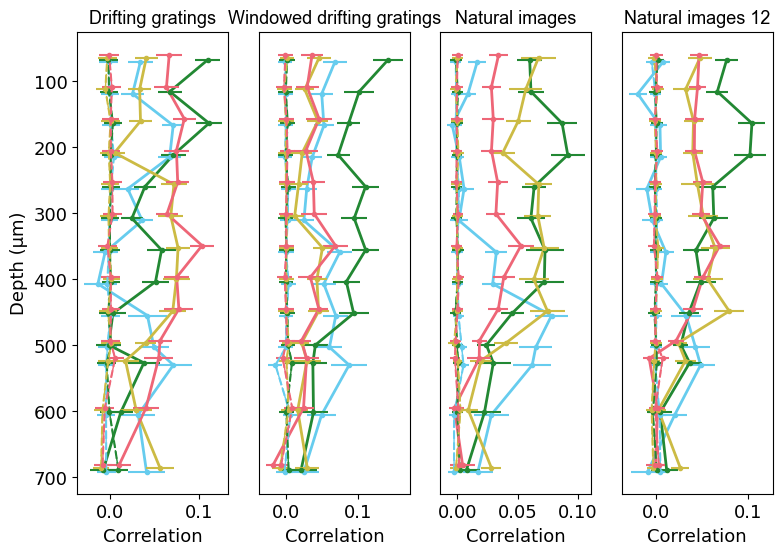

In [66]:
fig = plt.figure(figsize=(16, 6))
jitter_amount = 5
num_elements = len(mice)
jitter_step = jitter_amount * 2 / (num_elements - 1)
jitter_values = np.linspace(-jitter_amount, jitter_amount, num_elements)
fixed_jitters = np.tile(jitter_values, (n_z_groups, 1))
titles = ["Drifting gratings", "Windowed drifting gratings", "Natural images", "Natural images 12", "Natural movie"]

# for s in range(3):

for s, stim_type in enumerate(stim_types):
    ax = plt.subplot(1, 7, s+1)
    for m, mouse_id in enumerate(mice):

        means = []
        std_errors = []

        means_shuf = []
        std_errors_shuf = []
        mouse_color = mouse_colors[mice[m]]
        
        for z in range(n_z_groups):
            bootstrapped_values = bootstrapped_data[s, :, z, m]
            mean = np.mean(bootstrapped_values)
            std = np.std(bootstrapped_values)
            
            means.append(mean)
            std_errors.append(std)

            bootstrapped_values_shuf = bootstrapped_data_shuf[s, :, z, m]
            mean_shuf = np.mean(bootstrapped_values_shuf)
            std_shuf = np.std(bootstrapped_values_shuf)

            means_shuf.append(mean_shuf)
            std_errors_shuf.append(std_shuf)

        jitter = fixed_jitters[:, 3-m]
        y_positions = np.array([int(np.mean(x)) for x in z_groups_high_to_low]) + jitter
        
        plt.errorbar(means, y_positions, xerr=std_errors, fmt='o', color=mouse_color, ecolor=mouse_color, capsize=0, markersize=3)
        plt.plot(means, y_positions, color=mouse_color, linewidth=2)

        plt.errorbar(means_shuf, y_positions, xerr=std_errors_shuf, fmt='o', linestyle='--', color=mouse_color, ecolor=mouse_color, capsize=0, markersize=3)
        plt.plot(means_shuf, y_positions, color=mouse_color, linewidth=1, linestyle='--')

        plt.xlabel('Correlation', fontsize=fontsize)
        plt.title(titles[s], fontsize=fontsize, fontname='Arial')

    if s == 0: 
        plt.yticks(fontsize=fontsize)
        plt.ylabel("Depth (µm)", fontsize=fontsize)
    else:
        plt.yticks([])

    plt.xticks(fontsize=fontsize)
    plt.ylim(25, 725)
    plt.gca().invert_yaxis()

# fig.savefig(f"/home/naomi/Desktop/figures/v1dd_plots/3Dcorrelation_of_fractions_new_jitters_with_lines.eps", 
#             format='eps', bbox_inches='tight', dpi=300)